<a href="https://colab.research.google.com/github/apd1995/AMP_matrix_recovery/blob/apd1995-JS-hyperspectral/hyperspectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint recovery of hyperspectral images

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pywt
import numpy as np
import torch

We use the Indian pines dataset available at https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes for illustration.

In [ ]:
data = loadmat('Indian_pines.mat')
dat = data['indian_pines']
dat = np.transpose(dat, (2, 0, 1))

We can see that the image is made up of 220 slices (each corresponding to a wavelength) and each slice is of shape 145 by 145.

In [ ]:
dat.shape

(220, 145, 145)

In [ ]:
wave_obj = pywt.dwtn(dat, 'db2', mode = 'periodization')
wave_obj['aaa'].shape

(73, 73, 110)

In [ ]:
new_dat = np.zeros_like(dat, dtype = float)
for c in range(dat.shape[2]): # Assuming image has 3 channels (RGB)
    min_val = np.min(dat[:, :, c])
    max_val = np.max(dat[:, :, c])
    new_dat[:, :, c] = (dat[:, :, c] - min_val) / (max_val - min_val)


We can look at some of the slices.

In [ ]:
quantile_prob = 0.01 # sparsity level
original_slice_flat = original_slice.flatten()
cA, cD = pywt.dwt(original_slice_flat, 'db3')
cD_jitter = cD + np.random.normal(0, 1e-6, len(cD))
cD_max = np.abs(np.max(cD))
cD_inv = cD_max/cD_jitter
comparison_quantile = np.quantile(np.abs(cD_inv), quantile_prob)
cD_inv = np.where(np.abs(cD_inv)<comparison_quantile, cD_inv, np.inf)
cD_sparse = cD_max/cD_inv
recovered_slice_flat = pywt.idwt(cA, cD_sparse, 'db3')
recovered_slice_flat = recovered_slice_flat[0:(len(recovered_slice_flat)-1)]
recovered_slice = recovered_slice_flat.reshape(145, 145)

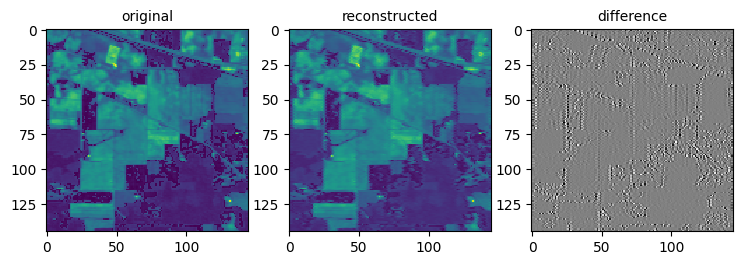

In [ ]:
fig = plt.figure(figsize = (12, 3))
ax = fig.add_subplot(1, 4, 1)
ax.set_title("original", fontsize=10)
ax.imshow(original_slice, interpolation="nearest")
ax = fig.add_subplot(1, 4, 2)
ax.set_title("reconstructed", fontsize=10)
ax.imshow(recovered_slice, interpolation="nearest")
ax = fig.add_subplot(1, 4, 3)
ax.set_title("difference", fontsize=10)
ax.imshow(original_slice - recovered_slice, interpolation = "nearest", cmap = plt.cm.gray)


Let's now do a wavelet decomposition flattening each slice and plot the difference coefficients in the same plot.

In [ ]:
for slice in range(20):
  quantile_prob = 0.1 # sparsity level
  original_slice_flat = original_slice.flatten()
  cA, cD = pywt.dwt(original_slice_flat, 'db3')
  cD_jitter = cD + np.random.normal(0, 1e-6, len(cD))
  cD_max = np.abs(np.max(cD))
  cD_inv = cD_max/cD_jitter
  comparison_quantile = np.quantile(np.abs(cD_inv), quantile_prob)
  cD_inv = np.where(np.abs(cD_inv)<comparison_quantile, cD_inv, np.inf)
  cD_sparse = cD_max/cD_inv
  recovered_slice_flat = pywt.idwt(cA, cD_sparse, 'db3')
  recovered_slice_flat = recovered_slice_flat[0:(len(recovered_slice_flat)-1)]
  recovered_slice = recovered_slice_flat.reshape(145, 145)

# Compressed sensing

In [ ]:
signal_ncol = 20
X_signal_nonsparse = np.zeros((len(cD), signal_ncol), dtype = float)
# quantile_prob = 0.1 # sparsity level
for slice in range(signal_ncol):
  original_slice = dat[:, :,slice]
  original_slice_flat = original_slice.flatten()
  cA, cD = pywt.dwt(original_slice_flat, 'db3')
  # cD_jitter = cD + np.random.normal(0, 1e-6, len(cD))
  # cD_max = np.abs(np.max(cD))
  # cD_inv = cD_max/cD_jitter
  # comparison_quantile = np.quantile(np.abs(cD_inv), quantile_prob)
  # cD_inv = np.where(np.abs(cD_inv)<comparison_quantile, cD_inv, np.inf)
  # cD_sparse = cD_max/cD_inv
  X_signal[:, slice] = cD

  # recovered_slice_flat = pywt.idwt(cA, cD_sparse, 'db3')
  # recovered_slice_flat = recovered_slice_flat[0:(len(recovered_slice_flat)-1)]
  # recovered_slice = recovered_slice_flat.reshape(145, 145)

In [ ]:
quantile_prob = 0.1 # sparsity level
row_norm_quantile = np.quantile(np.sum(np.abs(X_signal), axis = 1), 1 - quantile_prob)
zero_rows = (np.sum(np.abs(X_signal), axis = 1) < row_norm_quantile)
X_signal[zero_rows,:] = 0.0

In [ ]:
# joint sparsity
np.mean(np.sum(X_signal**2, axis = 1) != 0)

0.10004755111745126

(256, 256, 256)


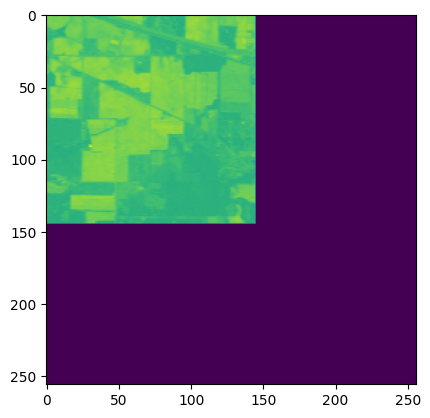

In [ ]:
# zero pad by artificially creating zero slices to make 256 by 256 by 256
import numpy as np

# Create a zero-filled tensor of the desired shape
padded_dat = np.zeros((2**int(np.ceil(np.log2(dat.shape[0]))), 2**int(np.ceil(np.log2(dat.shape[1]))), 2**int(np.ceil(np.log2(dat.shape[2])))))

# Calculate the starting indices to center the original tensor in the new tensor
start_x = 0 # (256 - 145) // 2
start_y = 0 # (256 - 145) // 2
start_z = 0 # (256 - 220) // 2

# Insert the original tensor into the zero-filled tensor
padded_dat[start_x:start_x+dat.shape[0], start_y:start_y+dat.shape[1], start_z:start_z+dat.shape[2]] = dat
print(padded_dat.shape)
plt.imshow(padded_dat[190, :, :])

Let's do a 3d wavelet decomposition. This is equivalent to doing a Haar decomposition along the spectral dimension and 2d wavelet decomposition along the spatial dimensions.

In [ ]:
dat = dat[:, :128, :128]

In [ ]:
wave_coeffs = pywt.wavedecn(dat, mode = 'periodization', wavelet = 'db2', level = 3)
# wave_coeffs = pywt.wavedecn(padded_dat, mode = 'periodization', wavelet = 'db2', level = 3)

In [ ]:
print(wave_coeffs[0].shape)
print(wave_coeffs[1].keys())
print([wave_coeffs[1][key].shape for key in wave_coeffs[1].keys()])

(16, 16, 16)
dict_keys(['aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'])
[(16, 16, 16), (16, 16, 16), (16, 16, 16), (16, 16, 16), (16, 16, 16), (16, 16, 16), (16, 16, 16)]


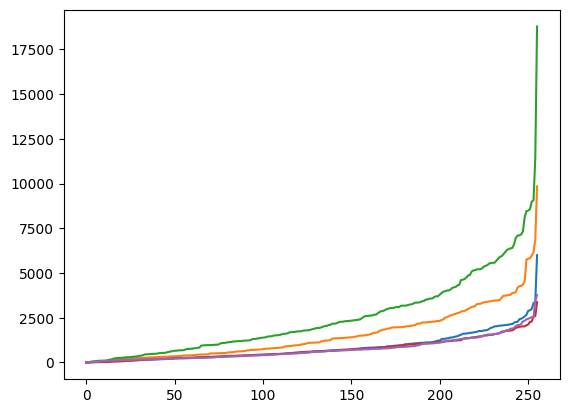

In [ ]:
plt.plot(np.sort((np.abs(wave_coeffs[1]['aad'][0,:,:]).flatten())))
plt.plot(np.sort((np.abs(wave_coeffs[1]['aad'][1,:,:]).flatten())))
plt.plot(np.sort((np.abs(wave_coeffs[1]['aad'][2,:,:]).flatten())))
plt.plot(np.sort((np.abs(wave_coeffs[1]['aad'][10,:,:]).flatten())))
plt.plot(np.sort((np.abs(wave_coeffs[1]['aad'][12,:,:]).flatten())))

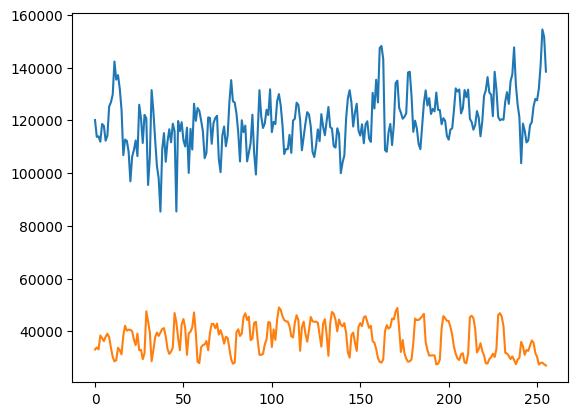

In [ ]:
plt.plot(wave_coeffs[0][5,:,:].flatten())
plt.plot(wave_coeffs[0][15,:,:].flatten())

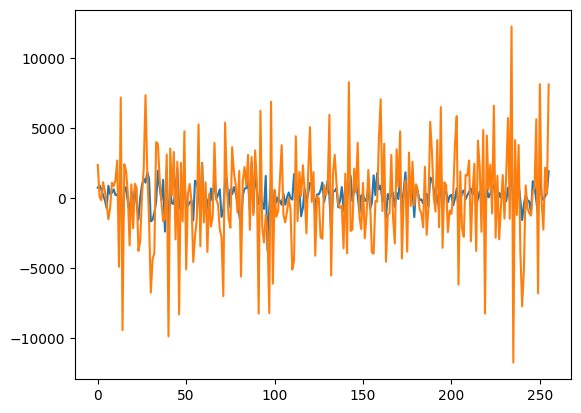

In [ ]:
plt.plot(wave_coeffs[1]['aad'][12,:,:].flatten())
plt.plot(wave_coeffs[1]['aad'][5,:,:].flatten())

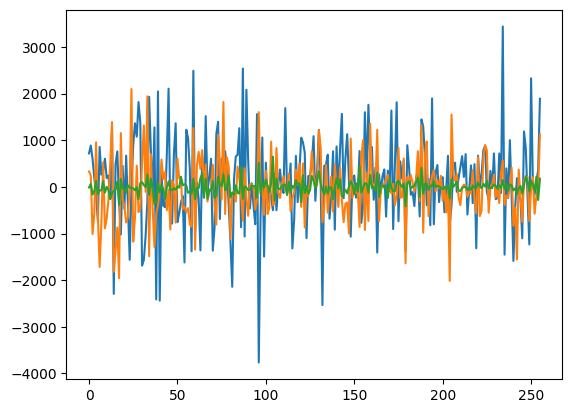

In [ ]:
plt.plot(wave_coeffs[1]['aad'][12,:,:].flatten())
plt.plot(wave_coeffs[1]['add'][12,:,:].flatten())
plt.plot(wave_coeffs[1]['ddd'][12,:,:].flatten())

It is quite interesting that after doing the 3d wavelet decomposition, we do indeed get 0's in all the slices. The following code checks this is indeed the case and counts such block-sparsity. Never mind, this was an artefact of zero-padding.

In [ ]:
def get_sparsity(coefs_dat):
  count_sum = 0
  for i in range(coefs_dat.shape[1]):
    for j in range(coefs_dat.shape[2]):
      if np.sum(coefs_dat[i, j, :]**2) == 0.:
        count_sum = count_sum + 1

  return count_sum/(coefs_dat.shape[1]*coefs_dat.shape[2])

In [ ]:
coefs_now = wave_coeffs[1]['aad']
get_sparsity(coefs_now)

0.0

Wow! We have about 41% joint sparsity! Let's try for the other difference coefficients.

In [ ]:
for key in list(wave_coeffs[1].keys()):
  coefs_now = wave_coeffs[1][key]
  joint_sparsity_level = get_sparsity(coefs_now)
  print('joint sparsity in ' + str(key) + ' is ' + str(joint_sparsity_level))

joint sparsity in aad is 0.4140625
joint sparsity in ada is 0.4140625
joint sparsity in add is 0.4140625
joint sparsity in daa is 0.4140625
joint sparsity in dad is 0.4140625
joint sparsity in dda is 0.4140625
joint sparsity in ddd is 0.4140625


We treat the difference coefficients as sparse mean plus noise and the nose level needs to be estimated. We choose MAD to ensure robustness.

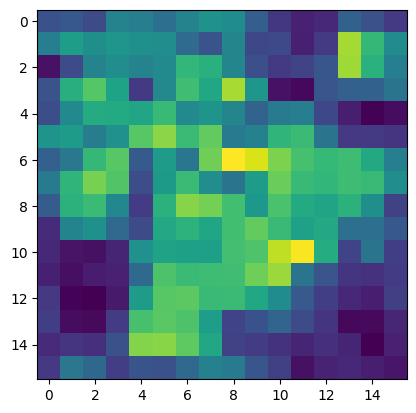

In [ ]:
plt.imshow(wave_coeffs[0][, :, :])

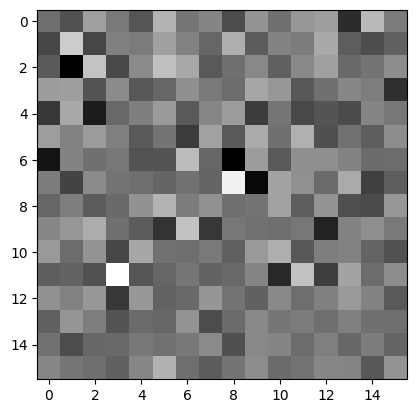

In [ ]:
coefs_now = wave_coeffs[1]['ddd'][0,:,:]
plt.imshow(coefs_now, cmap = 'gray')

# Haar + 2D: more interpretable

It seems applying a Haar along spectral dimension and then 2d slice-wise is more interpretable. Let's just go for that.

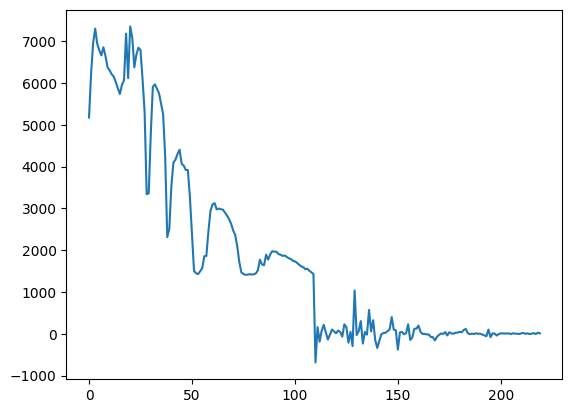

In [ ]:
haar_dat = np.zeros_like(dat, dtype = float)
for i in range(dat.shape[1]):
  for j in range(dat.shape[2]):
    cA, cD = pywt.dwt(dat[:, i, j], wavelet = 'haar', mode = 'periodization')
    haar_dat[:, i, j] = np.concatenate((cA, cD))

plt.plot(haar_dat[:, 0, 0])

In [ ]:
wave_dat = list()

for slice in range(haar_dat.shape[0]):
  haar_slice = haar_dat[slice, :, :]
  coeffs = pywt.wavedec2(haar_slice, "db2", level = 3, mode = "periodization")
  wave_dat = wave_dat + [coeffs]

In [ ]:
cH1_pooled = np.array([wave_dat[slice][3][0] for slice in range(len(wave_dat))])
cH1_pooled.shape

(220, 73, 73)

In [ ]:
def get_sparsified_array(original_array, prob_quantile):
  norm_list = np.array([np.sum(original_array[:, i, j]**2) for i in range(original_array.shape[1]) for j in range(original_array.shape[2])])
  quantile_threshold = np.quantile(norm_list, q = 1 - prob_quantile)
  sparse_array = np.zeros_like(original_array, dtype = float)
  for i in range(original_array.shape[1]):
    for j in range(original_array.shape[2]):
      if np.sum(original_array[:, i, j]**2)>quantile_threshold:
        sparse_array[:, i, j] = original_array[:, i, j]
  return sparse_array

sparsified_array = get_sparsified_array(cH1_pooled, 0.1)

We flatten each slice. We get a 2d matrix that needs to be transposed.

In [ ]:
sparsified_array_flat = torch.flatten(torch.tensor(sparsified_array), 1)
sparsified_array_flat = (np.transpose(sparsified_array_flat)).numpy()

Now we check how many row sums are nonzero that is the block sparsity.

In [ ]:
block_sparsity = np.mean(np.sum(sparsified_array_flat**2, axis = 1) != 0.)
block_sparsity

0.100018765246763

Let's initialize this as the signal matrix.

In [ ]:
X_signal = sparsified_array_flat[:, :10]

# Older code

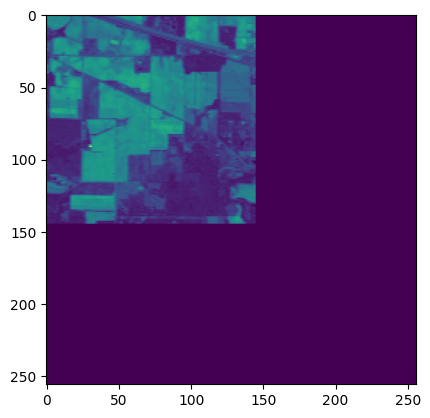

In [ ]:
haar_dat = np.zeros_like(padded_dat, dtype = float)

for i in range(padded_dat.shape[0]):
  for j in range(padded_dat.shape[1]):
    padded_dat_slice = padded_dat[i,j,:]
    cA_haar, cD_haar = pywt.dwt(padded_dat_slice, 'haar')
    haar_dat[i, j, :] = np.concatenate((cA_haar, cD_haar))

plt.imshow(haar_dat[:, :, 96])

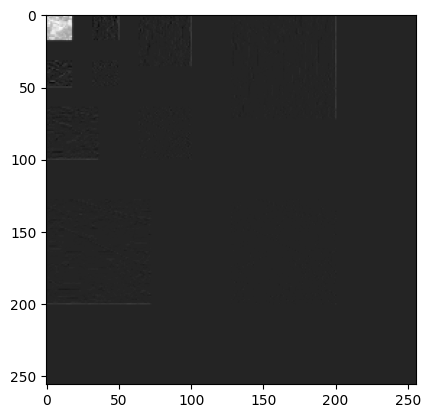

In [ ]:
wave_dat = np.zeros_like(haar_dat, dtype = float)

for slice in range(haar_dat.shape[2]):
  haar_dat_slice = haar_dat[:, :, slice]
  coeffs = pywt.wavedec2(haar_dat_slice, "db1", level = 3, mode = "periodization")
  cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
  wave_dat[:32, :32, slice] = cA3  # Upper left
  wave_dat[32:64, :32, slice] = cH3  # Upper right
  wave_dat[:32, 32:64, slice] = cV3  # Lower left
  wave_dat[32:64, 32:64, slice] = cD3
  wave_dat[64:128, :64, slice] = cH2
  wave_dat[:64, 64:128, slice] = cV2
  wave_dat[64:128, 64:128, slice] = cD2
  wave_dat[128:256, :128, slice] = cH1
  wave_dat[:128, 128:256, slice] = cV1
  wave_dat[128:256, 128:256, slice] = cD1
plt.imshow(wave_dat[:, :, 50], cmap = 'gray')

In [ ]:
wave_dat_approx_fiber = wave_dat[:32, :32, :]
wave_dat_cH3_fiber = wave_dat[32:64, :32, :]
wave_dat_cV3_fiber = wave_dat[:32, 32:64, :]
wave_dat_cD3_fiber = wave_dat[32:64, 32:64, :]
wave_dat_cH2_fiber = wave_dat[64:128, :64, :]
wave_dat_cV2_fiber = wave_dat[:64, 64:128, :]
wave_dat_cD2_fiber = wave_dat[64:128, 64:128, :]
wave_dat_cH1_fiber = wave_dat[128:256, :128, :]
wave_dat_cV1_fiber = wave_dat[:128, 128:256, :]
wave_dat_cD1_fiber = wave_dat[128:256, 128:256, :]

In [ ]:
cD3.shape

(32, 32)

# Comparison of norms

<ipython-input-185-9a282a3bd438>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wave_dat = torch.tensor(wave_dat)


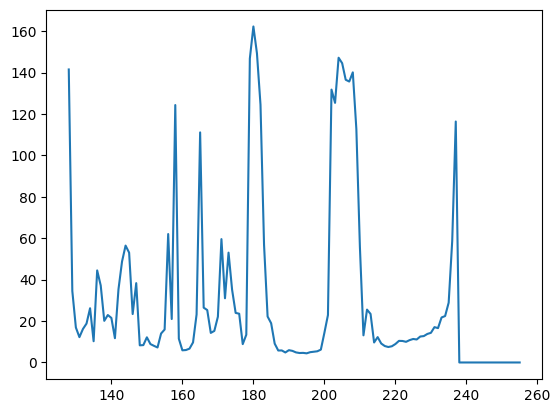

In [ ]:
wave_dat = torch.tensor(wave_dat)

def get_norm(df, norm_order):
  return torch.norm(torch.tensor(df), p = norm_order, dim = (0,1))

# approximation
wave_dat_approx_norm_1 = get_norm(wave_dat_cH2_fiber, 1)
plt.plot(range(128, 256), wave_dat_approx_norm_1[128:256])

In [ ]:
haar_dat_norm_2[10], torch.norm(torch.flatten(haar_dat[:,:,10]), p=2)

(tensor(66.8442, dtype=torch.float64), tensor(66.8442, dtype=torch.float64))

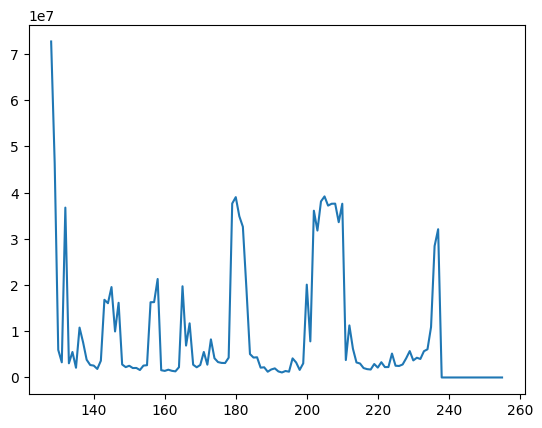

In [ ]:
plt.plot(range(128, 256), haar_dat_norm_half[128:256])

In [ ]:
x_test = 1.5**np.arange(20)
pywt.dwt(x_test, 'haar')

(array([1.76776695e+00, 3.97747564e+00, 8.94932020e+00, 2.01359704e+01,
        4.53059335e+01, 1.01938350e+02, 2.29361288e+02, 5.16062899e+02,
        1.16114152e+03, 2.61256843e+03]),
 array([-3.53553391e-01, -7.95495129e-01, -1.78986404e+00, -4.02719409e+00,
        -9.06118670e+00, -2.03876701e+01, -4.58722577e+01, -1.03212580e+02,
        -2.32228304e+02, -5.22513685e+02]))

In [ ]:
x = haar_dat[0:2, 0:2, 0:3]
print(x)
# print(torch.norm(x[:, :, 0], p = 1))
print("\nNext\n")
# z = torch.norm(x, p = 1, dim = (0,1))
# print(z)
z = torch.flatten(x, dim = (0, 1))
print(z)

# Approximate Message Passing

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 19 02:10:26 2023

@author: apratimdey
"""

import numpy as np
from numpy.random import Generator
import cvxpy as cvx
from pandas import DataFrame, concat
import time
# import amp_iteration as amp
# from minimax_tau_threshold import minimax_tau_threshold

# from EMS.manager import do_on_cluster, get_gbq_credentials, do_test_experiment, read_json, unroll_experiment
# from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster
# import dask
# import coiled
# import logging
# import json

# logging.basicConfig(level=logging.INFO)
# log_gbq = logging.getLogger('pandas_gbq')
# log_gbq.setLevel(logging.DEBUG)
# log_gbq.addHandler(logging.StreamHandler())
import jax
import jax.numpy as jnp
# logging.getLogger('jax').setLevel(logging.ERROR)


def seed(iter_count: int,
         nonzero_rows: float,
         num_measurements: float,
         signal_nrow: float,
         signal_ncol: float,
         err_tol: float,
         mc: float,
         sparsity_tol: float) -> int:
    return round(1 + round(iter_count*1000) + round(nonzero_rows * 1000) + round(num_measurements * 1000) + round(signal_nrow * 1000) + round(signal_ncol * 1000) + round(err_tol * 100000) + round(mc * 100000) + round(sparsity_tol * 1000000))


@jax.jit
def james_stein_nonsingular_vec(y,
                                Sigma_inv):
    d = len(y)
    quad_whitening = jnp.dot(y, jnp.dot(Sigma_inv, y))
    return jax.lax.cond(quad_whitening > (d-2),
                    lambda y: y * (1 - ((d-2)/quad_whitening)),   # True branch (lambda function)
                    lambda y: jnp.zeros(d),  # False branch (lambda function)
                    y)  # Operand to pass to selected branch


def james_stein_nonsingular(X: np.ndarray, Sigma_inv: np.ndarray) -> np.ndarray:
    """
    Applies james stein rowwise to denoise Y.

    Parameters
    ----------
    Y : np.ndarray
        Noisy signal.
    Sigma_inv : np.ndarray
        Noise precision matrix.

    Returns
    -------
    None.
    """
    d = X.shape[1]
    quad_whitening = np.sum(X * np.matmul(X, Sigma_inv), axis=1)
    james_stein_coeff = np.where(quad_whitening > (d-2), 1 - ((d-2)/quad_whitening), 0.0)
    return X * james_stein_coeff[:, np.newaxis]


@jax.jit
def james_stein_diagonal_vec(y,
                             diag_inv):
    d = len(y)
    quad_whitening = jnp.sum(diag_inv * y**2)
    return jax.lax.cond(quad_whitening > (d-2),
                    lambda y: y * (1 - ((d-2)/quad_whitening)),   # True branch (lambda function)
                    lambda y: jnp.zeros(d),  # False branch (lambda function)
                    y)  # Operand to pass to selected branch


def james_stein_diagonal(X, diag_inv):
    d = X.shape[1]
    quad_whitening = np.sum(X**2 * diag_inv, axis=1)
    james_stein_coeff = np.where(quad_whitening > (d-2), 1 - ((d-2)/quad_whitening), 0.0)
    return X * james_stein_coeff[:, np.newaxis]


@jax.jit
def james_stein_singular_vec(y,
                             Sigma_eigvecs,
                             nonzero_indices_int,
                             zero_indices_int,
                             Sigma_nonzero_eigvals_inv):

    # changing coordinates to get uncorrelated components
    y_indep = jnp.matmul(Sigma_eigvecs.T, y)

    y_indep_nonzero =  y_indep[jnp.array(nonzero_indices_int)]

    # apply denoiser on these coordinates to estimate the signal in the new basis on indep coordinates
    signal_newbasis_indep = james_stein_diagonal_vec(y_indep_nonzero, Sigma_nonzero_eigvals_inv)

    # when D has a 0 entry, it means we have perfect precision
    # zero_indices = ~nonzero_indices
    y_indep_zero = y_indep[jnp.array(zero_indices_int)]
    signal_newbasis_zero = y_indep_zero

    # combine the two to get signal_newbasis
    signal_newbasis = jnp.concatenate((signal_newbasis_zero, signal_newbasis_indep))
    # signal_newbasis = np.zeros(len(y), dtype = float)
    # signal_newbasis[nonzero_indices] = signal_newbasis_indep
    # signal_newbasis[zero_indices] = signal_newbasis_zero

    # we have identified U.T @ signal, now we need to get signal i.e revert to original coordinates
    signal_originalbasis = jnp.matmul(Sigma_eigvecs, signal_newbasis)

    return signal_originalbasis



def james_stein_singular(X, Sigma_eigvecs,
                         nonzero_indices_int, zero_indices_int, Sigma_nonzero_eigvals_inv):
    # changing coordinates to get uncorrelated components
    X_indep = np.matmul(X, Sigma_eigvecs)

    X_indep_nonzero =  X_indep[:, nonzero_indices_int]

    # apply denoiser on these coordinates to estimate the signal in the new basis on indep coordinates
    signal_newbasis_indep = james_stein_diagonal(X_indep_nonzero, Sigma_nonzero_eigvals_inv)

    # when D has a 0 entry, it means we have perfect precision
    # zero_indices = ~nonzero_indices
    X_indep_zero = X_indep[:, zero_indices_int]
    signal_newbasis_zero = X_indep_zero

    # combine the two to get signal_newbasis
    signal_newbasis = np.zeros(X.shape, dtype = float)
    signal_newbasis[:, nonzero_indices_int] = signal_newbasis_indep
    signal_newbasis[:, zero_indices_int] = signal_newbasis_zero

    # we have identified U.T @ signal, now we need to get signal i.e revert to original coordinates
    signal_originalbasis = np.matmul(signal_newbasis, Sigma_eigvecs.T)

    return signal_originalbasis


def update_signal_noisy(A: float,
                        signal_denoised_prev: float,
                        Residual_prev: float):
    return signal_denoised_prev + np.matmul(A.T, Residual_prev)


def update_signal_denoised_nonsingular(signal_noisy_current: float,
                                       noise_cov_current_inv: float):
    return james_stein_nonsingular(signal_noisy_current, noise_cov_current_inv)


def update_signal_denoised_singular(signal_noisy_current: float,
                                    noise_cov_current_eigvecs: float,
                                    noise_cov_current_nonzero_indices_int,
                                    noise_cov_current_zero_indices_int,
                                    noise_cov_current_nonzero_eigvals_inv: float):
    return james_stein_singular(signal_noisy_current, noise_cov_current_eigvecs,
                                            noise_cov_current_nonzero_indices_int,
                                            noise_cov_current_zero_indices_int,
                                            noise_cov_current_nonzero_eigvals_inv)


@jax.jit
def james_stein_onsager_nonsingular(X,
                                    Z,
                                    Sigma_inv):
    X = jnp.array(X)
    dd_jacobian = jax.jacfwd(james_stein_nonsingular_vec, argnums=0)
    # dd_jacobian = jax.jit(jax.jacfwd(james_stein_nonsingular_vec, argnums=0))
    jac_vectorized = jax.vmap(dd_jacobian, in_axes = (0, None))
    sum_jacobians = jac_vectorized(X, Sigma_inv).sum(axis = 0)
    onsager_term = jnp.matmul(Z, sum_jacobians.T)
    return onsager_term / Z.shape[0]


@jax.jit
def james_stein_onsager_singular(X,
                                 Z,
                                 Sigma_eigvecs,
                                 nonzero_indices_int,
                                 zero_indices_int,
                                 Sigma_nonzero_eigvals_inv):
    X = jnp.array(X)
    # selected_rows = rng.choice(X.shape[0], int(selected_rows_frac*X.shape[0]), replace = False)
    dd_jacobian = jax.jacfwd(james_stein_singular_vec, argnums=0)
    # dd_jacobian = jax.jit(jax.jacfwd(james_stein_singular_vec, argnums=0))
    jac_vectorized = jax.vmap(dd_jacobian, in_axes = (0, None, None, None, None))
    sum_jacobians = jac_vectorized(X, Sigma_eigvecs, nonzero_indices_int, zero_indices_int, Sigma_nonzero_eigvals_inv).sum(axis = 0)
    onsager_term = jnp.matmul(Z, sum_jacobians.T)
    return onsager_term / Z.shape[0]


# def warm_up():
#     y = np.ones(5, dtype = float)
#     Sigma_inv = np.eye(5, dtype = float)
#     res1 = james_stein_nonsingular_vec(y, Sigma_inv)
#     res2 = james_stein_diagonal_vec(y, np.ones(5, dtype = float))
#     res3 = james_stein_singular_vec(y, Sigma_inv, np.array([0,1,2]), np.array([3,4]), np.ones(3, dtype = float))
#     res4 = james_stein_onsager_nonsingular(np.ones((1000,5), dtype = float), Sigma_inv, Sigma_inv, np.array([0]), 1.0)
#     res5 = james_stein_onsager_singular(np.ones((1000,5), dtype = float), Sigma_inv, Sigma_inv, np.array([0,1,2]), np.array([3,4]), np.ones(3, dtype = float), np.array([0]), 1.0)
#     return True


def update_residual_singular(A: float,
                             Y: float,
                             signal_noisy_current: float,
                             signal_denoised_current: float,
                             Residual_prev: float,
                             noise_cov_current_eigvecs: float,
                             noise_cov_current_nonzero_indices_int,
                             noise_cov_current_zero_indices_int,
                             noise_cov_current_nonzero_eigvals_inv: float):
    naive_residual = Y - np.matmul(A, signal_denoised_current)
    onsager_term_ = james_stein_onsager_singular(signal_noisy_current,
                                                         Residual_prev,
                                                         noise_cov_current_eigvecs,
                                                         noise_cov_current_nonzero_indices_int,
                                                         noise_cov_current_zero_indices_int,
                                                         noise_cov_current_nonzero_eigvals_inv)
    return naive_residual + onsager_term_


def update_residual_nonsingular(A: float,
                                Y: float,
                                signal_noisy_current: float,
                                signal_denoised_current: float,
                                Residual_prev: float,
                                noise_cov_current_inv: float):
    naive_residual = Y - np.matmul(A, signal_denoised_current)
    onsager_term_ = james_stein_onsager_nonsingular(signal_noisy_current,
                                                            Residual_prev,
                                                            noise_cov_current_inv)
    return naive_residual + onsager_term_


def amp_iteration_nonsingular(A: float,
                              Y: float,
                              signal_denoised_prev: float,
                              Residual_prev: float,
                              noise_cov_current_inv: float):
    signal_noisy_current = update_signal_noisy(A, signal_denoised_prev, Residual_prev)
    # noise_cov_current = Residual_prev.T @ Residual_prev/A.shape[0]
    signal_denoised_current = update_signal_denoised_nonsingular(signal_noisy_current, noise_cov_current_inv)
    Residual_current = update_residual_nonsingular(A,
                                                   Y,
                                                   signal_noisy_current,
                                                   signal_denoised_current,
                                                   Residual_prev,
                                                   noise_cov_current_inv)
    return {'signal_denoised_current': signal_denoised_current,
            'Residual_current': Residual_current}


def amp_iteration_singular(A: float,
                           Y: float,
                           signal_denoised_prev: float,
                           Residual_prev: float,
                           noise_cov_current_eigvecs: float,
                           noise_cov_current_nonzero_indices_int,
                           noise_cov_current_zero_indices_int,
                           noise_cov_current_nonzero_eigvals_inv: float):
    signal_noisy_current = update_signal_noisy(A, signal_denoised_prev, Residual_prev)
    # noise_cov_current = Residual_prev.T @ Residual_prev/A.shape[0]
    signal_denoised_current = update_signal_denoised_singular(signal_noisy_current, noise_cov_current_eigvecs,
                                                              noise_cov_current_nonzero_indices_int,
                                                              noise_cov_current_zero_indices_int,
                                                              noise_cov_current_nonzero_eigvals_inv)
    Residual_current = update_residual_singular(A, Y, signal_noisy_current, signal_denoised_current, Residual_prev,
                                                noise_cov_current_eigvecs, noise_cov_current_nonzero_indices_int,
                                                noise_cov_current_zero_indices_int,
                                                noise_cov_current_nonzero_eigvals_inv)
    return {'signal_denoised_current': signal_denoised_current,
            'Residual_current': Residual_current}


# def warm_up_2():
#     res1 = amp_iteration_nonsingular(np.eye(1000), np.eye(1000), 2*np.eye(1000), np.eye(1000), np.eye(1000), np.array([0]), 1.0)
#     res2 = amp_iteration_singular(np.eye(3), np.eye(3), 2*np.eye(3), np.eye(3), np.eye(3), np.arange(2), np.array([2]), np.ones(2, dtype = float), np.array([0]), 1.0)
#     return True


def gen_iid_normal_mtx(num_measurements, signal_nrow, rng):
    """
    Generates a single random num_measurements by signal_nrow matrix with iid signal_nrow(0,1) entries

    Parameters
    ----------
    num_measurements : int
        Number of rows of measurement matrix.
    signal_nrow : int
        Number of rows of signal matrix.

    Returns
    -------
    numpy.ndarray
        num_measurements by signal_nrow matrix.

    """
    return rng.normal(0, 1, (num_measurements, signal_nrow))


def recovery_stats(X_true: float,
              X_rec: float,
              sparsity_tol: float,
              A: np.ndarray,
              Y_true: np.ndarray):

    N, B = X_true.shape
    n = Y_true.shape[0]
    Y_rec = np.matmul(A, X_rec)

    zero_indices_true = (np.apply_along_axis(np.linalg.norm, 1, X_true)==0)
    zero_indices_rec = (np.apply_along_axis(np.linalg.norm, 1, X_rec)/np.sqrt(B)<=sparsity_tol)

    nonzero_indices_true = (np.apply_along_axis(np.linalg.norm, 1, X_true)!=0)
    nonzero_indices_rec = (np.apply_along_axis(np.linalg.norm, 1, X_rec)/np.sqrt(B)>sparsity_tol)

    dict_observables = {
                'rel_err': cvx.norm(X_true-X_rec, "fro").value/cvx.norm(X_true, "fro").value,
                'rel_err_measurements': cvx.norm(Y_true-Y_rec, "fro").value/cvx.norm(Y_true, "fro").value,
                'avg_err': cvx.norm(X_true - X_rec, "fro").value/np.sqrt(N*B),
                'avg_err_measurements': cvx.norm(Y_true - Y_rec, "fro").value/np.sqrt(n*B),
                'max_row_err': cvx.mixed_norm(X_true - X_rec, 2, np.inf).value/np.sqrt(B),
                'max_row_err_measurements': cvx.mixed_norm(Y_true - Y_rec, 2, np.inf).value/np.sqrt(B),
                'norm_2_1_true': cvx.mixed_norm(X_true, 2, 1).value/(N*np.sqrt(B)),
                'norm_2_1_rec': cvx.mixed_norm(X_rec, 2, 1).value/(N*np.sqrt(B)),
                'norm_2_2_true': cvx.mixed_norm(X_true, 2, 2).value/np.sqrt(N*B),
                'norm_2_2_rec': cvx.mixed_norm(X_rec, 2, 2).value/np.sqrt(N*B),
                'norm_2_infty_true': cvx.mixed_norm(X_true, 2, np.inf).value/np.sqrt(B),
                'norm_2_infty_rec': cvx.mixed_norm(X_rec, 2, np.inf).value/np.sqrt(B),
                'soft_sparsity': np.mean(np.apply_along_axis(np.linalg.norm, 1, X_rec)/np.sqrt(B) > sparsity_tol),
                'nonzero_rows_rec': np.sum(np.apply_along_axis(np.linalg.norm, 1, X_rec)/np.sqrt(B) > sparsity_tol),
                'tpr': sum(zero_indices_true * zero_indices_rec)/max(1, sum(zero_indices_true)),
                'tnr': sum(nonzero_indices_true * nonzero_indices_rec)/max(1, sum(nonzero_indices_true)),
                'norm_2_1_true_measurements': cvx.mixed_norm(Y_true, 2, 1).value/(n*np.sqrt(B)),
                'norm_2_1_rec_measurements': cvx.mixed_norm(Y_rec, 2, 1).value/(n*np.sqrt(B)),
                'norm_2_2_true_measurements': cvx.mixed_norm(Y_true, 2, 2).value/np.sqrt(n*B),
                'norm_2_2_rec_measurements': cvx.mixed_norm(Y_rec, 2, 2).value/np.sqrt(n*B),
                'norm_2_infty_true_measurements': cvx.mixed_norm(Y_true, 2, np.inf).value/np.sqrt(B),
                'norm_2_infty_rec_measurements': cvx.mixed_norm(Y_rec, 2, np.inf).value/np.sqrt(B)
                }

    return dict_observables


def add_row_to_df(dict_to_add, df):
    return concat([df, DataFrame(dict_to_add, index = [0])], ignore_index=True)


def run_amp_instance(**dict_params):

    k = dict_params['nonzero_rows']
    n = dict_params['num_measurements']
    N = dict_params['signal_nrow']
    B = dict_params['signal_ncol']
    err_tol = dict_params['err_tol']
    mc = dict_params['mc']
    sparsity_tol = dict_params['sparsity_tol']
    max_iter = dict_params['max_iter']
    err_explosion_tol = dict_params['err_explosion_tol']

    iter_count = 0

    rng = np.random.default_rng(seed=seed(iter_count, k, n, N, B, err_tol, mc, sparsity_tol))
    signal_true = np.zeros((N, B), dtype=float)
    nonzero_indices = rng.choice(range(N), k, replace=False)
    # signal_true[nonzero_indices, :] = rng.normal(0, 1, (k, B))
    # signal_true[nonzero_indices, :] = rng.poisson(2, (k, B))
    signal_true[nonzero_indices, :] = rng.binomial(1, 0.5, (k, B))
    signal_true = np.array(signal_true)

    A = gen_iid_normal_mtx(n, N, rng)/np.sqrt(n)
    Y_true = np.matmul(A, signal_true)

    sparsity = k/N
    dict_params['sparsity'] = sparsity
    dict_params['undersampling_ratio'] = n/N

    output_df = None

    iter_count = 0

    signal_denoised_current = np.zeros((N, B), dtype = float)
    Residual_current = Y_true

    dict_observables = recovery_stats(signal_true,
                               signal_denoised_current,
                               sparsity_tol,
                               A,
                               Y_true)
    rel_err = dict_observables['rel_err']
    # rec_stats_dict['iter_count'] = iter_count
    min_rel_err = rel_err

    while iter_count<max_iter and rel_err>err_tol and rel_err<err_explosion_tol:
        tick = time.perf_counter()

        iter_count = iter_count + 1

        # signal_denoised_prev = signal_denoised_current
        # signal_denoised_current = None
        # Residual_prev = Residual_current
        # Residual_current = None
        # noise_cov_current = np.matmul(Residual_prev.T, Residual_prev)/n
        noise_cov_current = np.cov(Residual_current.T)
        # noise_cov_current_diag = np.diag(np.var(Residual_prev, axis = 0))

        D, U = np.linalg.eigh(noise_cov_current)
        D = np.round(D, 10)

        if np.all(D > 0):
            noise_cov_current_inv = np.matmul(U * 1.0/D, U.T)
            dict_current = amp_iteration_nonsingular(A, Y_true,
                                                     signal_denoised_current,
                                                     Residual_current, noise_cov_current_inv)
        else:
            nonzero_indices = (D > 0)
            nonzero_indices_int = np.where(nonzero_indices)[0]
            zero_indices_int = np.where(~nonzero_indices)[0]
            D_nonzero_inv = 1/D[nonzero_indices_int]
            dict_current = amp_iteration_singular(A, Y_true,
                                                  signal_denoised_current,
                                                  Residual_current,
                                                  U, nonzero_indices_int, zero_indices_int, D_nonzero_inv)

        signal_denoised_current = dict_current['signal_denoised_current']
        Residual_current = dict_current['Residual_current']
        dict_observables = recovery_stats(signal_true,
                                   signal_denoised_current,
                                   sparsity_tol,
                                   A,
                                   Y_true)
        rel_err = dict_observables['rel_err']
        min_rel_err = min(rel_err, min_rel_err)
        tock = time.perf_counter() - tick
        if iter_count % 50 == 0:
            dict_observables['avg_trace_resid_cov'] = np.mean(D)
            dict_observables['min_rel_err'] = min_rel_err
            dict_observables['iter_count'] = iter_count
            dict_observables['time_seconds'] = round(tock, 2)
            combined_dict = {**dict_params, **dict_observables}
            output_df = add_row_to_df(combined_dict, output_df)

    if iter_count % 50 != 0:
        dict_observables['avg_trace_resid_cov'] = np.mean(D)
        dict_observables['min_rel_err'] = min_rel_err
        dict_observables['iter_count'] = iter_count
        dict_observables['time_seconds'] = round(tock, 2)
        combined_dict = {**dict_params, **dict_observables}
        output_df = add_row_to_df(combined_dict, output_df)

    #return DataFrame(data = {**dict_params, **dict_observables}).set_index('iter_count')
    return output_df


def test_experiment() -> dict:
    exp = {'table_name':'amp-test',
           'params': [{
               'nonzero_rows': [30],
               'num_measurements': [320],
               'signal_nrow': [1000],
               'signal_ncol': [5],
               'max_iter': [1],
               'err_tol': [1e-5],
               'sparsity_tol': [1e-4],
               'err_explosion_tol': [100],
               'mc': [0],
               'selected_rows_frac': [1.0]
                }]
           }
    # exp = dict(table_name='amp-integer-grids',
    #             base_index=0,
    #             db_url='sqlite:///data/EMS.db3',
    #             multi_res=[{
    #                 'nonzero_rows': list(range(1, 100)),
    #                 'num_measurements': list(range(1, 100)),
    #                 'signal_nrow': [100],
    #                 'signal_ncol': [1, 2, 3, 4, 5],
    #                 'mc': list(range(100)),
    #                 'err_tol': [1e-5],
    #                 'sparsity_tol': [1e-4]
    #             }])
    # exp = dict(table_name='comr-N50-larger-grids',
    #             base_index=0,
    #             db_url='sqlite:///data/EMS.db3',
    #             multi_res=[{
    #                 'nonzero_rows': list(range(1, 50)),
    #                 'num_measurements': list(range(1, 50)),
    #                 'signal_nrow': [50],
    #                 'signal_ncol': [1, 2, 3, 4, 5],
    #                 'mc': list(range(100)),
    #                 'err_tol': [1e-5],
    #                 'sparsity_tol': [1e-4]
    #             }])
    return exp

def do_sherlock_experiment(json_file: str):
    exp = read_json(json_file)
    nodes = 1000
    with SLURMCluster(queue='normal,owners,donoho,hns,stat',
                      cores=1, memory='4GiB', processes=1,
                      walltime='24:00:00') as cluster:
        cluster.scale(jobs=nodes)
        logging.info(cluster.job_script())
        with Client(cluster) as client:
            do_on_cluster(exp, run_amp_instance, client, credentials=get_gbq_credentials())
        cluster.scale(0)


def do_coiled_experiment(json_file: str):
    exp = read_json(json_file)
    # logging.info(f'{json.dumps(dask.config.config, indent=4)}')
    software_environment = 'adonoho/amp_matrix_recovery'
    # coiled.delete_software_environment(name=software_environment)
    logging.info('Creating environment.')
    coiled.create_software_environment(
        name=software_environment,
        conda="environment-coiled.yml",
        pip=[
            "git+https://GIT_TOKEN@github.com/adonoho/EMS.git"
        ]
    )
    with coiled.Cluster(software=software_environment,
                        n_workers=960, worker_vm_types=['n1-standard-1'],
                        use_best_zone=True, spot_policy='spot') as cluster:
        with Client(cluster) as client:
            do_on_cluster(exp, run_amp_instance, client, credentials=get_gbq_credentials())


def do_local_experiment():
    exp = test_experiment()
    logging.info(f'{json.dumps(dask.config.config, indent=4)}')
    with LocalCluster(dashboard_address='localhost:8787') as cluster:
        with Client(cluster) as client:
            # do_on_cluster(exp, run_amp_instance, client, credentials=None)
            do_on_cluster(exp, run_amp_instance, client, credentials=get_gbq_credentials())


def read_and_do_local_experiment(json_file: str):
    exp = read_json(json_file)
    with LocalCluster(dashboard_address='localhost:8787', n_workers=32) as cluster:
        with Client(cluster) as client:
            # do_on_cluster(exp, run_amp_instance, client, credentials=None)
            do_on_cluster(exp, run_amp_instance, client, credentials=get_gbq_credentials())


def do_test_exp():
    exp = test_experiment()
    with LocalCluster(dashboard_address='localhost:8787') as cluster:
        with Client(cluster) as client:
            do_test_experiment(exp, run_amp_instance, client, credentials=get_gbq_credentials())


def do_test():
    exp = test_experiment()
    print(exp)
    pass
    df = run_amp_instance(dict_params = exp)
    df.to_csv("temp.csv")


def count_params(json_file: str):
    exp = read_json(json_file)
    params = unroll_experiment(exp)
    logging.info(f'Count of instances: {len(params)}.')




In [ ]:
def run_amp_instance(X_signal,
                     nonzero_rows,
                     num_measurements,
                     err_tol,
                     mc,
                     sparsity_tol,
                     max_iter,
                     err_explosion_tol):

    k = nonzero_rows
    n = num_measurements
    N = X_signal.shape[0]
    B = X_signal.shape[1]
    dict_params = {'nonzero_rows': k, 'num_measurements': n, 'signal_nrow': N, 'signal_ncol': B, 'mc': mc}

    iter_count = 0

    rng = np.random.default_rng(seed=seed(iter_count, k, n, N, B, err_tol, mc, sparsity_tol))
    signal_true = X_signal

    A = gen_iid_normal_mtx(n, N, rng)/np.sqrt(n)
    Y_true = np.matmul(A, signal_true)

    sparsity = k/N
    dict_params['sparsity'] = sparsity
    dict_params['undersampling_ratio'] = n/N

    output_df = None

    iter_count = 0

    signal_denoised_current = np.zeros((N, B), dtype = float)
    Residual_current = Y_true

    dict_observables = recovery_stats(signal_true,
                               signal_denoised_current,
                               sparsity_tol,
                               A,
                               Y_true)
    rel_err = dict_observables['rel_err']
    # rec_stats_dict['iter_count'] = iter_count
    min_rel_err = rel_err

    while iter_count<max_iter and rel_err>err_tol and rel_err<err_explosion_tol:
        tick = time.perf_counter()

        iter_count = iter_count + 1

        # signal_denoised_prev = signal_denoised_current
        # signal_denoised_current = None
        # Residual_prev = Residual_current
        # Residual_current = None
        # noise_cov_current = np.matmul(Residual_prev.T, Residual_prev)/n
        noise_cov_current = np.cov(Residual_current.T)
        # noise_cov_current_diag = np.diag(np.var(Residual_prev, axis = 0))

        D, U = np.linalg.eigh(noise_cov_current)
        D = np.round(D, 10)

        if np.all(D > 0):
            noise_cov_current_inv = np.matmul(U * 1.0/D, U.T)
            dict_current = amp_iteration_nonsingular(A, Y_true,
                                                     signal_denoised_current,
                                                     Residual_current, noise_cov_current_inv)
        else:
            nonzero_indices = (D > 0)
            nonzero_indices_int = np.where(nonzero_indices)[0]
            zero_indices_int = np.where(~nonzero_indices)[0]
            D_nonzero_inv = 1/D[nonzero_indices_int]
            dict_current = amp_iteration_singular(A, Y_true,
                                                  signal_denoised_current,
                                                  Residual_current,
                                                  U, nonzero_indices_int, zero_indices_int, D_nonzero_inv)

        signal_denoised_current = dict_current['signal_denoised_current']
        Residual_current = dict_current['Residual_current']
        dict_observables = recovery_stats(signal_true,
                                   signal_denoised_current,
                                   sparsity_tol,
                                   A,
                                   Y_true)
        rel_err = dict_observables['rel_err']
        min_rel_err = min(rel_err, min_rel_err)
        tock = time.perf_counter() - tick
        print("iter count: " + str(iter_count))
        if iter_count % 50 == 0:
            dict_observables['avg_trace_resid_cov'] = np.mean(D)
            dict_observables['min_rel_err'] = min_rel_err
            dict_observables['iter_count'] = iter_count
            dict_observables['time_seconds'] = round(tock, 2)
            combined_dict = {**dict_params, **dict_observables}
            output_df = add_row_to_df(combined_dict, output_df)

    if iter_count % 50 != 0:
        dict_observables['avg_trace_resid_cov'] = np.mean(D)
        dict_observables['min_rel_err'] = min_rel_err
        dict_observables['iter_count'] = iter_count
        dict_observables['time_seconds'] = round(tock, 2)
        combined_dict = {**dict_params, **dict_observables}
        output_df = add_row_to_df(combined_dict, output_df)

    #return DataFrame(data = {**dict_params, **dict_observables}).set_index('iter_count')
    return output_df


In [ ]:
df = run_amp_instance(X_signal,
                 np.sum(np.sum(X_signal**2, axis = 1)!=0.),
                 1170,
                 1e-4,
                 0,
                 1e-4,
                 1000,
                 100)

iter count: 1
iter count: 2
iter count: 3
iter count: 4
iter count: 5
iter count: 6
iter count: 7
iter count: 8
iter count: 9
iter count: 10
iter count: 11
iter count: 12
iter count: 13
iter count: 14
iter count: 15
iter count: 16
iter count: 17
iter count: 18
iter count: 19
iter count: 20
iter count: 21
iter count: 22
iter count: 23
iter count: 24
iter count: 25
iter count: 26
iter count: 27
iter count: 28
iter count: 29
iter count: 30
iter count: 31
iter count: 32
iter count: 33
iter count: 34
iter count: 35
iter count: 36
iter count: 37
iter count: 38
iter count: 39
iter count: 40
iter count: 41
iter count: 42
iter count: 43
iter count: 44
iter count: 45
iter count: 46
iter count: 47
iter count: 48
iter count: 49
iter count: 50
iter count: 51
iter count: 52
iter count: 53
iter count: 54
iter count: 55
iter count: 56
iter count: 57
iter count: 58
iter count: 59
iter count: 60
iter count: 61
iter count: 62
iter count: 63
iter count: 64
iter count: 65
iter count: 66
iter count: 67
iter

In [ ]:
df.to_csv("temp.csv")

# Tracking similarities across slices

In [ ]:
dat
dat_transposed = np.transpose(dat, (2, 0, 1))
dat_transposed.shape

(220, 145, 145)

In [ ]:
print(dat[:, :, 0])
print(dat_transposed[0, :, :])

[[3172 2580 3687 ... 2570 3170 3172]
 [2576 2747 2750 ... 3859 3686 2744]
 [2744 2576 2744 ... 2570 2576 2742]
 ...
 [3324 2983 2988 ... 2564 2730 3156]
 [3161 2727 2988 ... 3156 3159 2561]
 [2979 2977 2814 ... 3153 3155 3323]]
[[3172 2580 3687 ... 2570 3170 3172]
 [2576 2747 2750 ... 3859 3686 2744]
 [2744 2576 2744 ... 2570 2576 2742]
 ...
 [3324 2983 2988 ... 2564 2730 3156]
 [3161 2727 2988 ... 3156 3159 2561]
 [2979 2977 2814 ... 3153 3155 3323]]


We create a data matrix whose each column is each flattened slice/face. After that we apply PCA.

In [ ]:
X_samples = np.zeros((dat_transposed.shape[1]*dat_transposed.shape[2], dat_transposed.shape[0]), dtype = float)
for i in range(dat_transposed.shape[0]):
    X_samples[:, i] = dat_transposed[i, :, :].flatten()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_samples = scaler.fit_transform(X_samples)
pca = PCA()  # for example, reducing to 2 components
pca.fit(X_samples)  # 'data' is your numpy array

PCA()

In [ ]:
np.mean(X_samples[:, 0]), np.std(X_samples[:, 10]) # checking standardization

(5.407221770350346e-17, 1.0000000000000089)

In [ ]:
transformed_data = pca.transform(X_samples)

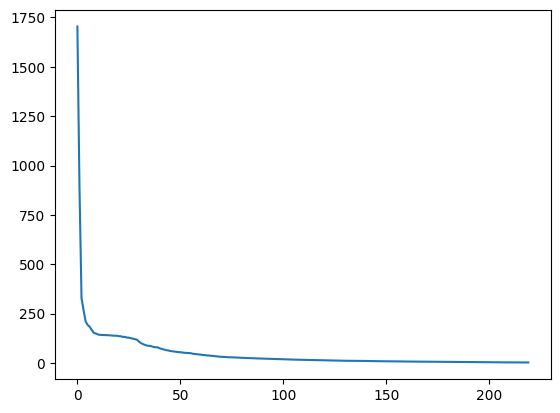

In [ ]:
plt.plot(pca.singular_values_)

In [ ]:
!pip install screenot

In [ ]:
from screenot.ScreeNOT import adaptiveHardThresholding
adaptiveHardThresholding(X_samples, )

(array([[-0.02917087,  0.67289336,  0.74593325, ...,  0.72450462,
          0.47574529,  0.41749162],
        [ 0.0422677 ,  0.8664036 ,  0.97413015, ...,  0.95708728,
          0.60809999,  0.57906244],
        [ 0.06087299,  0.94012925,  1.06063172, ...,  1.04895946,
          0.66170963,  0.64074311],
        ...,
        [ 0.12896902, -0.8499679 , -0.95873215, ..., -1.07018676,
         -0.6902712 , -0.62280247],
        [ 0.14445403, -0.79106996, -0.9090129 , ..., -1.10705343,
         -0.69829179, -0.65972769],
        [ 0.15147095, -0.794563  , -0.91080964, ..., -1.10363765,
         -0.69880198, -0.65433537]]),
 283.0034557604738,
 3)

# Verifying something about commutativity of wavelets

In [ ]:
x = np.random.normal(0, 1, (4, 4))

array([[ 1.03937046,  0.51793257,  2.0336168 ,  0.80466645],
       [ 0.3429845 ,  1.34319416,  2.51587595, -0.31730346],
       [ 0.01962449, -0.88301941,  0.07900751, -0.17425095],
       [ 0.00433193, -0.37339206,  0.81010371, -0.61424996]])

In [ ]:
wav2 = pywt.dwt2(x, 'db2', mode = 'periodization')
wav2

(array([[ 0.75695802,  2.48733799],
        [-0.42977969,  0.75973003]]),
 (array([[ 0.03785125,  1.9065618 ],
         [-0.89169422, -0.9154204 ]]),
  array([[-0.9733977 , -0.86213069],
         [-0.72156257, -0.71357804]]),
  array([[ 0.53941378, -0.78655207],
         [ 0.09153954, -0.20877967]])))

In [ ]:
wav1_rows = np.zeros((4, 4), dtype = float)
for row in range(x.shape[0]):
  cA, cD = pywt.dwt(x[row, :], 'db2', mode = 'periodization')
  wav1_rows[row, :] = np.concatenate((cA, cD))

wav1_rows

array([[ 1.11099642,  1.99715245, -0.88600247, -0.35170893],
       [ 0.10915675,  2.63777713, -0.12728675, -1.16881859],
       [-0.27588825, -0.40197144, -0.7586668 , -0.05867959],
       [-0.4815649 ,  0.35908949, -0.62507978, -0.64918156]])

In [ ]:
wav1_cols = np.zeros((4, 4), dtype = float)
for col in range(wav1_rows.shape[1]):
  cA, cD = pywt.dwt(wav1_rows[:, col], 'db2', mode = 'periodization')
  wav1_cols[:, col] = np.concatenate((cA, cD))

plt.imshow(wav1_cols)

array([[ 0.75695802,  2.48733799, -0.9733977 , -0.86213069],
       [-0.42977969,  0.75973003, -0.72156257, -0.71357804],
       [ 0.03785125,  1.9065618 ,  0.53941378, -0.78655207],
       [-0.89169422, -0.9154204 ,  0.09153954, -0.20877967]])

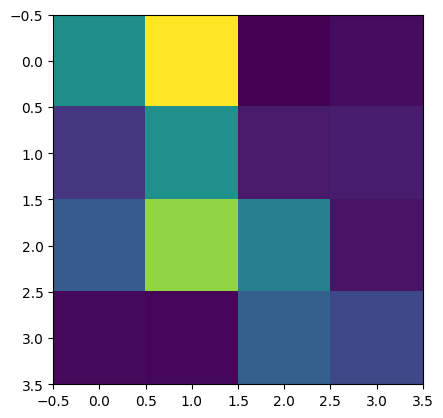

In [ ]:
plt.imshow(wav1_cols)

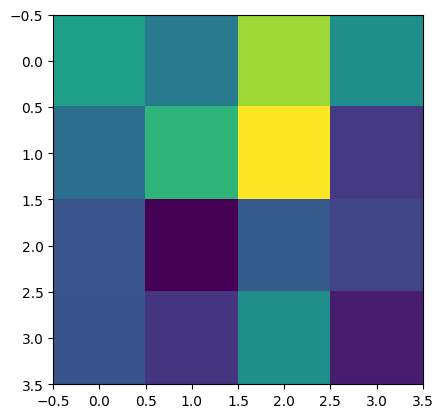

In [ ]:
plt.imshow(x)

In [ ]:
y = np.zeros(256**8)

ValueError: ignored